In [1]:
# This notebook contains the processing of orthologs, measuring intronic conservation, 
# and correlating conservation to splicing factor activity. The orthologs are taken
# from the Mazin paper mentioned below.

# Genomes: Chicken - galus4, Human - hg19, Rabbit - oryCun2 , Mouse - mm10, Opossum - monDom5

# Mazin et al. Alternative splicing during mammalian organ development. 
# Nat Genet 53, 925–934 (2021). https://doi.org/10.1038/s41588-021-00851-w

import pyranges
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import logomaker
import re
from pyfaidx import Fasta
from Bio.Seq import Seq 
import random
from scipy.stats import hypergeom
from scipy import stats


Matplotlib is building the font cache; this may take a moment.


In [2]:
# This path represents where I store relevant the data I import in.
# I also made a list of acceptable chromososomes.

database = '/Users/nrk/Desktop/PhD/Thesis/Database/'
keep_chr = ['chr' + str(i) for i in range(1, 40)] + ['X', 'Y', 'W', 'Z']


In [3]:
# Orthologs between the subset of species
# By dropping NA, I obtain the orthologs shared among selected species
# I am leaving chicken out of this analysis

species = ['human', 'mouse', 'rabbit', 'opossum']
orthologs = pd.read_csv(database + 'Supplementary_Data_8.csv').dropna(subset = species)
filtered_orthologs = orthologs.dropna(subset = species)


In [4]:
# Obtaining the shorted name for the ortholog to match with the SAJR file

human_info = np.array([[i.split(':')[0]] + ['chr' + i.split(':')[1]] + i.split(':')[2:] for i in filtered_orthologs['human']])
mouse_info =  np.array([[i.split(':')[0]] + ['chr' + i.split(':')[1]] + i.split(':')[2:] for i in filtered_orthologs['mouse']])
rabbit_info =  np.array([[i.split(':')[0]] + ['chr' + i.split(':')[1]] + i.split(':')[2:] for i in filtered_orthologs['rabbit']])
opossum_info =  np.array([[i.split(':')[0]] + ['chr' + i.split(':')[1]] + i.split(':')[2:] for i in filtered_orthologs['opossum']])
#chicken_info =  np.array([[i.split(':')[0]] + ['chr' + i.split(':')[1]] + i.split(':')[2:] for i in filtered_orthologs['chicken']])

matching = pd.DataFrame({'human': human_info[:, 0], 'human_chr': human_info[:, 1], 'human_strand': human_info[:, 2], 'human_start': human_info[:, 3].astype(int), 'human_end': human_info[:, 4].astype(int), \
                         'mouse': mouse_info[:, 0], 'mouse_chr': mouse_info[:, 1], 'mouse_strand': mouse_info[:, 2], 'mouse_start': mouse_info[:, 3].astype(int), 'mouse_end': mouse_info[:, 4].astype(int), \
                         'rabbit': rabbit_info[:, 0], 'rabbit_chr': rabbit_info[:, 1], 'rabbit_strand': rabbit_info[:, 2], 'rabbit_start': rabbit_info[:, 3].astype(int), 'rabbit_end': rabbit_info[:, 4].astype(int), \
                         'opossum': opossum_info[:, 0], 'opossum_chr': opossum_info[:, 1], 'opossum_strand': opossum_info[:, 2], 'opossum_start': opossum_info[:, 3].astype(int), 'opossum_end': opossum_info[:, 4].astype(int)})
                         #'chicken': chicken_info[:, 0], 'chicken_chr': chicken_info[:, 1], 'chicken_strand': chicken_info[:, 2], 'chicken_start': chicken_info[:, 3].astype(int), 'chicken_end': chicken_info[:, 4].astype(int)})

# Ensuring chromosome is acceptable according to list above

matching = matching.loc[matching[['human_chr', 'mouse_chr', 'rabbit_chr', 'opossum_chr']].isin(keep_chr).all(axis=1), :]

In [5]:
# SAJR files are the splicing results. Type EXN is constitutive exons, and ALT is alternative. INT is ignored, but there are very few.
# I remove 'chr' leading string and ensure whatever is found in the ortholog list

species_sajr = {}

for i in species:
    current_sajr = pyranges.read_gff3(database + i + '.sajr.gz').as_df()
    current_sajr['Chromosome'] = current_sajr['Chromosome'].apply(lambda x: 'chr' + x)
    species_sajr[i] = current_sajr.loc[(current_sajr[' segment_id'].isin(matching[i]))]

In [11]:
# Dataframe with constitutive/alternative orthologs. Must be constitutive in every species.
# Coordinates exist in this dataframe

human_const = species_sajr['human'].loc[species_sajr['human'][' type'] == 'EXN'][' segment_id']
mouse_const = species_sajr['mouse'].loc[species_sajr['mouse'][' type'] == 'EXN'][' segment_id']
rabbit_const = species_sajr['rabbit'].loc[species_sajr['rabbit'][' type'] == 'EXN'][' segment_id']
opossum_const = species_sajr['opossum'].loc[species_sajr['opossum'][' type'] == 'EXN'][' segment_id']
#chicken_const = species_sajr['chicken'].loc[species_sajr['chicken'][' type'] == 'EXN'][' segment_id']

constitutive_orthologs = matching.loc[(matching['human'].isin(human_const)) & (matching['mouse'].isin(mouse_const)) & (matching['rabbit'].isin(rabbit_const))\
& (matching['opossum'].isin(opossum_const)), :] #& (matching['chicken'].isin(chicken_const)), :]

alternative_orthologs = pd.merge(matching, constitutive_orthologs, how="outer", indicator=True)
alternative_orthologs = alternative_orthologs[alternative_orthologs['_merge']=='left_only'].drop('_merge', axis=1)


In [12]:
# Pulling coordinates for the constitutive/alternative orthologs. Adding flanking 500 nt to the exon.
# Will use the proximal 200 nt for conservation. 

# Strands are 1 base off, so I shift negative strand by 1 to align.
# Only run this once, because if you run it twice you will shift your df by too much. 
# If you accidentally run it twice, just rerun the cell above and proceed.

genome_dict = {'human': 'hg19.fa', 'mouse': 'mm10.fa', 'rabbit': 'oryCun2.fa',  'opossum': 'monDom5.fa'}  # 'chicken': 'galGal4.fa'

length_interest = 250

#Adjusts start, end, and deep coordinates for both strands.
                        
def adjust_coordinates(df, organism, length_interest):
    
    plus_strand = df[f"{organism}_strand"] == '+'
    minus_strand = df[f"{organism}_strand"] == '-'

    # Adjust start and end coordinates
    df.loc[plus_strand, f"{organism}_start"] -= length_interest
    df.loc[plus_strand, f"{organism}_end"] += length_interest

    df.loc[minus_strand, f"{organism}_start"] -= length_interest + 1
    df.loc[minus_strand, f"{organism}_end"] += length_interest - 1
    

# Fetches the sequence from the genome and reverse complements if strand is negative

def fetch_sequence(row, genome, organism):

    seq = genome[row[f'{organism}_chr']][row[f'{organism}_start']:row[f'{organism}_end']].seq.upper()
    return str(Seq(seq).reverse_complement()) if row[f'{organism}_strand'] == '-' else seq

# Iterate through species

for organism in species:
    
    genome = Fasta(f'/Users/nrk/Desktop/PhD/Database/{genome_dict[organism]}')

    # Adjust coordinates for both constitutive and alternative orthologs
    adjust_coordinates(constitutive_orthologs, organism, length_interest)
    adjust_coordinates(alternative_orthologs, organism, length_interest)

    # Fetch sequences
    constitutive_orthologs.loc[:, f'{organism}_seq'] = constitutive_orthologs.apply(lambda row: fetch_sequence(row, genome, organism), axis=1)
    
    alternative_orthologs.loc[:, f'{organism}_seq'] = alternative_orthologs.apply(lambda row: fetch_sequence(row, genome, organism), axis=1)


/var/folders/dp/nsc9s3s53s14vhxd4f8frf980000gn/T/ipykernel_2176/2392991067.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constitutive_orthologs.loc[:, f'{organism}_seq'] = constitutive_orthologs.apply(lambda row: fetch_sequence(row, genome, organism), axis=1)
/var/folders/dp/nsc9s3s53s14vhxd4f8frf980000gn/T/ipykernel_2176/2392991067.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constitutive_orthologs.loc[:, f'{organism}_seq'] = constitutive_orthologs.apply(lambda row: fetch_sequence(row, genom

In [13]:
# Filtering introns by checking whether an exon overlaps with them. I allowed a 5 nt buffer space to avoid false positives.
# Extended ortholog sequence is at least 250 nt away from any splice site. This allows me to use the extended sequence as deep intronic control later.
# I have attempted this important filtering step in several ways.
# This was the (1) least amount of code and (2) fastest method I tried.
# I did this in humans, and extrapolated everything to the other organisms.
# Recall: Start and End mean the start and end of the intronic regions, not the exon start and end.
# Technically, I mixed the names of the up/down names, but the filtering process comes out to be the same since both are used to filter out short introns.

const_ortho_pyranges_down = pyranges.PyRanges(pd.DataFrame({'Chromosome': constitutive_orthologs['human_chr'], 'Start': constitutive_orthologs['human_start'] - 245, \
              'End' : constitutive_orthologs['human_start'] + 245, 'Strand': constitutive_orthologs['human_strand'], 'Label': constitutive_orthologs.index}))

const_ortho_pyranges_up = pyranges.PyRanges(pd.DataFrame({'Chromosome': constitutive_orthologs['human_chr'], 'Start': constitutive_orthologs['human_end'] - 245, \
              'End' : constitutive_orthologs['human_end'] + 245, 'Strand': constitutive_orthologs['human_strand'], 'Label': constitutive_orthologs.index}))

alt_ortho_pyranges_down = pyranges.PyRanges(pd.DataFrame({'Chromosome': alternative_orthologs['human_chr'], 'Start': alternative_orthologs['human_start'] - 245, \
              'End' : alternative_orthologs['human_start'] + 245, 'Strand': alternative_orthologs['human_strand'], 'Label': alternative_orthologs.index}))

alt_ortho_pyranges_up = pyranges.PyRanges(pd.DataFrame({'Chromosome': alternative_orthologs['human_chr'], 'Start': alternative_orthologs['human_end'] - 245, \
              'End' : alternative_orthologs['human_end'] + 245, 'Strand': alternative_orthologs['human_strand'], 'Label': alternative_orthologs.index}))

all_exons = pd.read_csv(database + 'human_exons_NCBI_RefSeq', sep = '\t', header = None)
    
all_exons = pyranges.PyRanges(chromosomes = all_exons[0], starts = all_exons[1], ends = all_exons[2], strands = all_exons[5])

# Indices to remove from dataframe because they have exons overlapping with intronic region of interest

const_down_results = list(np.unique(const_ortho_pyranges_down.intersect(all_exons, invert = False).Label))
const_up_results = list(np.unique(const_ortho_pyranges_up.intersect(all_exons, invert = False).Label))
alt_down_results = list(np.unique(alt_ortho_pyranges_down.intersect(all_exons, invert = False).Label))
alt_up_results = list(np.unique(alt_ortho_pyranges_up.intersect(all_exons, invert = False).Label))

filter_out_const = constitutive_orthologs.index.isin(const_down_results + const_up_results)
filter_out_alt = alternative_orthologs.index.isin(const_down_results + const_up_results)

# These are the the final dataframes
final_constitutive_orthologs = constitutive_orthologs[~filter_out_const].copy()
final_alternative_orthologs = alternative_orthologs[~filter_out_alt].copy()

In [10]:
# Taking random samples for the 5' and the 3' sequences. Manual UCSC BLAT for quality control.

bad = alternative_orthologs.index.isin(alt_down_results + alt_up_results)
good = alternative_orthologs[bad]

testing = random.choice(range(0,len(good)))
good.iloc[testing, :]['human_seq']


'GGAGTTTGTGTTCTCCGTCCTCGTGCGGGAGAGCAAGGCCAGTGCAGTGGGTGATGATGACAAGGTGTACTACTTCTTCACGGAGCGTGCCACTGAGGAGGGCTCTGGCAGCTTCACTCAGAGCCGCAGCAGTCACCGTGTGGCCCGTGTGGCTCGTGTCTGCAAGGTGGATTGGGCTGACGTTGGGGCACGGGTATAGAGGCTGGACCTCTGACCCTGGCCCCTTATCCCGTGCCTCTACCTCCCCAGGGAGACCTGGGAGGGAAGAAGATCCTGCAGAAGAAGTGGACTTCCTTCCTGAAAGCCCGTCTCATCTGCCACATTCCACTGTATGAGACACTGCGTGGGGTCTGCAGCCTGGATGCTGAAACCTCAAGCCGTACACACTTCTATGCAGCCTTCACGCTGAGCACACAGTGGTCAGTGCAGGGACAATCGGGAGGCAAGAAACTGCGGACAGCATAGGGGCTGGAGCAGAGGTCAATGAGGATGAGATAGGATCCACTGTGGGGAGGTCTGGCTGCAAAGTGAGAATTTTTTTTTTTTTTTAAGAGGGAGTCTTGCTCTGTTGCCAGGCTGGAGTGCAGTGGCGCGATCTCGGCTCACTGCAATCTCCGCCTCCCGGGTTCAAGTGATTATCCTGCCTCGGCCTCCCGAGTAGCTGGGACT'

human


/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00493784 0.00314493 0.66572613 0.67998119 0.11033712 0.20054081
 0.33691914 0.25400464 0.25012492 0.2509185 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00458513 0.01137466 0.02848073 0.07101079 0.06051788 0.1368486
 0.16729859 0.21276783 0.22849249 0.21720601]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:

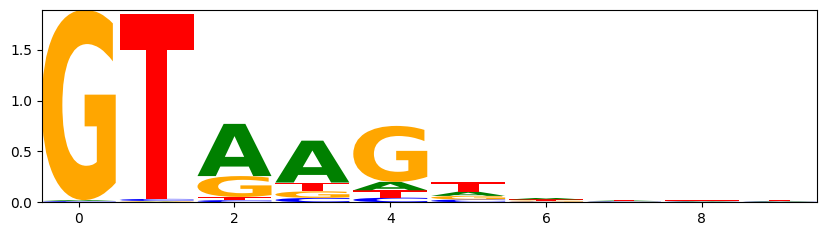

/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.99468007 0.00191047 0.26420363 0.24357053 0.27790024]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00126385 0.00379155 0.14322664 0.18314082 0.21414925]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

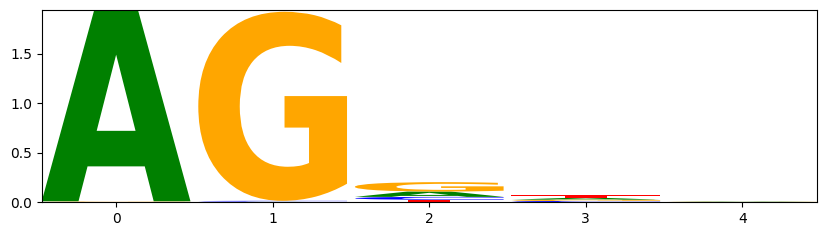


mouse


/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00452622 0.00296849 0.6583882  0.68392899 0.09334587 0.18254761
 0.31824594 0.23342347 0.22419469 0.22719257]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0042617  0.0114625  0.03003762 0.07926758 0.06495415 0.14918881
 0.18863155 0.23348225 0.25576064 0.24241712]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py

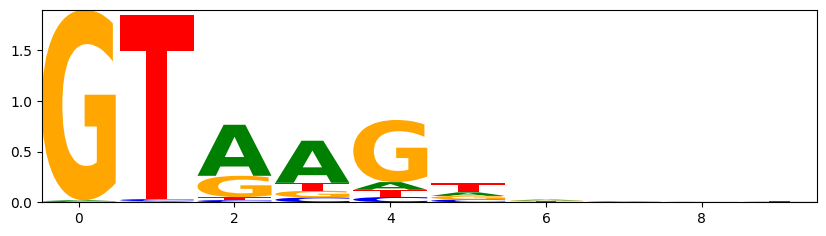

/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.99591465 0.00146955 0.26081589 0.24035975 0.27048554]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00123442 0.0036151  0.14328121 0.18639784 0.22457677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

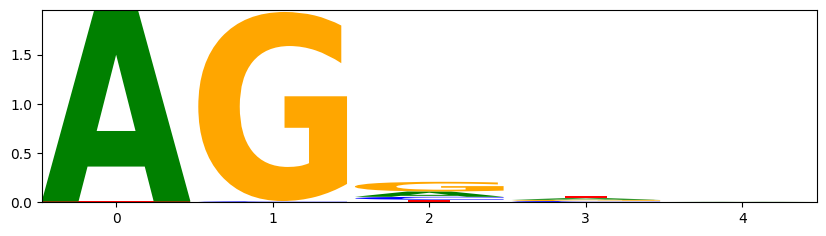

/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00467276 0.00314456 0.63693537 0.67558116 0.09833368 0.18341317
 0.30919564 0.22611456 0.22267611 0.22182385]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00467276 0.01069739 0.03041702 0.08537338 0.06386105 0.15299615
 0.18332501 0.24545214 0.26008758 0.24274841]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py


rabbit


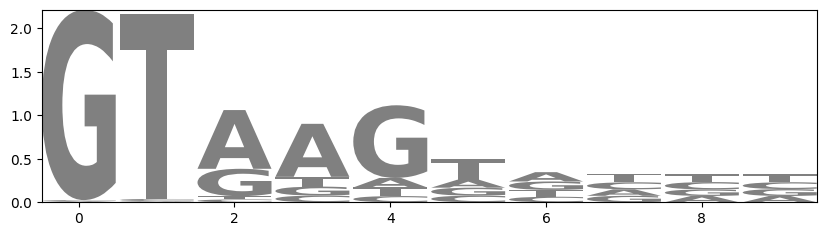

/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.9949158  0.00176331 0.25894143 0.23725277 0.26423135]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00146942 0.00423193 0.14750051 0.18981985 0.22864196]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

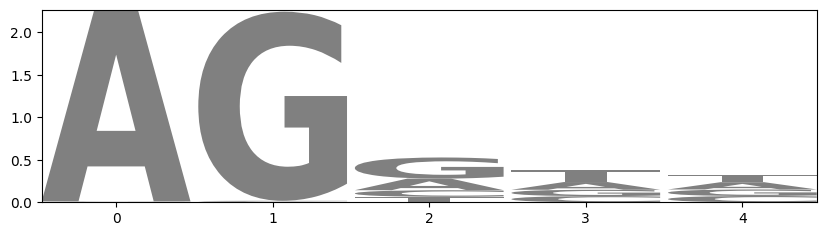

/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00464351 0.00346794 0.70463763 0.70231588 0.11902663 0.21254335
 0.35775583 0.28199024 0.26758949 0.26867689]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00414389 0.01028625 0.02659731 0.05848469 0.05284194 0.11767472
 0.15485217 0.19079527 0.21195556 0.2003174 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py


opossum


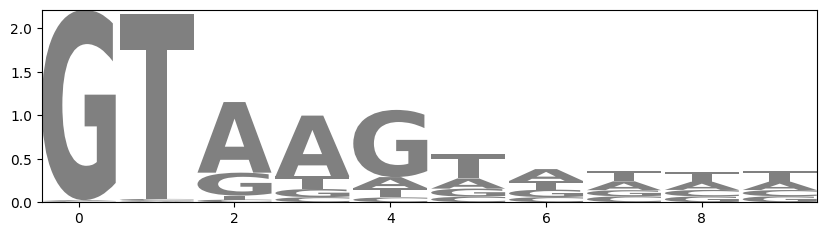

/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.99494504 0.00217481 0.26900018 0.24648798 0.28557574]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00135191 0.00367366 0.13751249 0.17657086 0.2055487 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
/opt/anaconda3/envs/3ss/lib/python3.12/site-packages/logomaker/src/matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

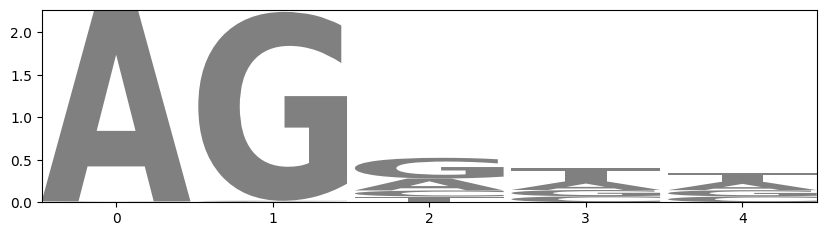

In [17]:
# Can use logos to double check the sequences are SS and aligned

for organism in species:
    seq = [i[-250:-240] for i in alternative_orthologs[f'{organism}_seq'] if (len(i) > 500)]
    print(f'{organism}')
    
    matrix = logomaker.alignment_to_matrix(seq, to_type='information')
    logomaker.Logo(matrix)
    plt.show()
    
    logomaker.Logo(logomaker.alignment_to_matrix([i[247:252].upper() for i in alternative_orthologs[f'{organism}_seq'] if (len(i) > 500)], to_type='information'))
    plt.show()
    print('')

In [9]:
# Function that calculates motif conservation within +/-edge distance from human position

# In theory, should loop through motifs inside of loop instead. That way you do not reindex the sequence everytime.
# This will only matter if you analyze at scale where you test many motifs.

def ortho_seq_conserved_motif(motif, species, series_sequences, length5, length3, edge):

    conserved_position5 = np.zeros(length5)
    enrichment_position5 = np.zeros((len(species), length5))
    
    conserved_position3 = np.zeros(length3)
    enrichment_position3 = np.zeros((len(species), length3))
    
    for row in (series_sequences.iterrows()):
        
        temp_organism_array5 = np.zeros((len(species), length5))
        temp_organism_array3 = np.zeros((len(species), length3))
    
        for ind, organism in enumerate(species):
            
            checking_seq = row[1][f'{organism}_seq']
            
            # Exons at least 10 nt long
            if len(checking_seq) > length5 * 2 + 10:
                temp_organism_array5[ind, [m.start() for m in re.finditer(motif, checking_seq[-length5:])]] += 1
                temp_organism_array3[ind, [m.start() for m in re.finditer(motif, checking_seq[:length3])]] += 1
            
                enrichment_position5[ind] += temp_organism_array5[ind]
                enrichment_position3[ind] += temp_organism_array3[ind]
    
    
        if np.all(temp_organism_array5.sum(axis = 1) > 0):
        # Human-centric
            for num in np.where(temp_organism_array5[0] > 0)[0]:
                start_idx = max(0, num - edge)
                end_idx = min(length5, num + edge)
                if np.any(temp_organism_array5[:, start_idx:end_idx] > 0, axis = 1).all():
                    conserved_position5[num] += 1
                    
        if np.all(temp_organism_array3.sum(axis = 1) > 0):
        # Human-centric
            for num in np.where(temp_organism_array3[0] > 0)[0]:
                start_idx = max(0, num - edge)
                end_idx = min(length3, num + edge)
                
                if np.any(temp_organism_array3[:, start_idx:end_idx] > 0, axis = 1).all():
                    conserved_position3[num] += 1

    # return only human values for enrichment, but can change to other species
    return conserved_position5, enrichment_position5[0], conserved_position3, enrichment_position3[0]

In [10]:
# Statistical test near splice site region vs. background. Hypergeometric survival function, same as a one-way Fisher-exact test.
# I am storing the p-values and using them to plot signifance later

def hypergeom_stat_test(total_motif_foreground, total_motif_background, conserved_motif_foreground, conserved_motif_background):

    significance_list = []
    background_error = 0
    
    for i in range(0, 200, 10):
        
        #M = total_motif_foreground[i:i+10].sum() + int(np.mean([total_motif_background[j:j+10].sum() for j in range(0,50, 10)]))
        M = total_motif_foreground[i:i+10].sum() + total_motif_background.sum()
        n = total_motif_foreground[i:i+10].sum()
        #N = conserved_motif_foreground[i:i+10].sum() + int(np.mean([conserved_motif_background[j:j+10].sum() for j in range(0, 50, 10)]))
        N = conserved_motif_foreground[i:i+10].sum() + conserved_motif_background.sum()
        k = conserved_motif_foreground[i:i+10].sum()
        
        significance_list.append(hypergeom.sf(k-1, M, n, N))
    
    p = (conserved_motif_background.sum() / total_motif_background.sum())
    one_p = 1 - p
    
    background_error = 2 * np.sqrt((p * one_p) / total_motif_background.sum())

    return significance_list, background_error
    


In [11]:

def plot_ss_conserved(motif, alt_conserve_5results, total_alt_motif5, alt_conserve_3results, total_alt_motif3, \
                    const_conserve_5results, total_const_motif5, const_conserve_3results, total_const_motif3,\
                     save_fig_option):

    bin_size = 10
    
    # Enrichment
    
    X5 = range(5, 200+5, bin_size)
    X3 = range(5, 200+5, bin_size)
    
    # Conservation Figure
    
    # Taking the sum of last 50 nt conserved/total as background. Each const/alt exons have their own background conservation for both the 5ss and 3ss sequences.

    # Significance - Hypergeometric test

    five_alt_stats, five_alt_back_error = hypergeom_stat_test(total_alt_motif5[0:200], total_alt_motif5[200:250], alt_conserve_5results[0:200], alt_conserve_5results[200:250])
    five_const_stats, five_const_back_error = hypergeom_stat_test(total_const_motif5[0:200], total_const_motif5[200:250], const_conserve_5results[0:200], const_conserve_5results[200:250])

    three_alt_stats, three_alt_back_error = hypergeom_stat_test(total_alt_motif3[50:250], total_alt_motif3[0:50], alt_conserve_3results[50:250], alt_conserve_3results[0:50])
    three_const_stats, three_const_back_error = hypergeom_stat_test(total_const_motif3[50:250], total_const_motif3[0:50], const_conserve_3results[50:250], const_conserve_3results[0:50])

    # Customizable error bar features
    
    error_kw = dict(ecolor='grey',  
                elinewidth=1, 
                capsize=2)
    
    fig, axs = plt.subplots(2, 2, figsize = (12,8))

    # TOP LEFT 
    
    bars = axs[0, 0].bar(X3, np.reshape(const_conserve_3results[50:250], (-1, bin_size)).sum(axis=1) / np.reshape(total_const_motif3[50:250], (-1, bin_size)).sum(axis=1), color = 'steelblue', alpha = 0.75, width = bin_size)   
    
    for ind, bar in enumerate(bars[:]):
        x = bar.get_x() + bar.get_width() / 2 
        y = bar.get_height() 
        if three_const_stats[ind] < 0.05:
            axs[0, 0].text(x, y + 0.02, '*', ha='center', va='bottom', fontsize=12)
   
    back = const_conserve_3results[:50].sum()/total_const_motif3[:50].sum()
    axs[0, 0].axhline(y=back, color='red', linestyle='--', label = 'Background Conservation +/- 2 SD')
    axs[0, 0].axhspan(max(back - three_const_back_error, 0), back + three_const_back_error, facecolor='red', alpha=0.25)  
    axs[0, 0].set_title('3ss Constitutive Exons')

    # TOP RIGHT
    
    bars = axs[0, 1].bar(X5, np.reshape(const_conserve_5results[0:200], (-1, bin_size)).sum(axis=1) / np.reshape(total_const_motif5[0:200], (-1, bin_size)).sum(axis=1), color = 'steelblue', alpha = 0.75, width = bin_size)

    for ind, bar in enumerate(bars[:]):
        x = bar.get_x() + bar.get_width() / 2 
        y = bar.get_height() 
        if five_const_stats[ind] < 0.05:
            axs[0, 1].text(x, y + 0.02, '*', ha='center', va='bottom', fontsize=12)

    back = const_conserve_5results[-50:].sum()/total_const_motif5[-50:].sum()
    axs[0, 1].axhline(y=back, color='red', linestyle='--', label = 'Background Conservation +/- 2 SD')
    axs[0, 1].axhspan(max(0, back - five_const_back_error), back + five_const_back_error, facecolor='red', alpha=0.25)    
    axs[0, 1].set_title('5ss Constitutive Exons')


    # BOTTOM LEFT
    bars = axs[1, 0].bar(X3, np.reshape(alt_conserve_3results[50:250], (-1, bin_size)).sum(axis=1) / np.reshape(total_alt_motif3[50:250], (-1, bin_size)).sum(axis=1), color = 'coral', alpha = 0.75, width = bin_size)

    for ind, bar in enumerate(bars[:]):
        x = bar.get_x() + bar.get_width() / 2 
        y = bar.get_height() 
        if three_alt_stats[ind] < 0.05:
            axs[1, 0].text(x, y + 0.02, '*', ha='center', va='bottom', fontsize=12)

    back = alt_conserve_3results[:50].sum()/total_alt_motif3[:50].sum()
    axs[1, 0].axhline(y=back, color='blue', linestyle='--', label = 'Background Conservation +/- 2 SD')
    axs[1, 0].set_title('3ss Alternative Exons')
    axs[1, 0].axhspan(max(0, back - three_alt_back_error), back + three_alt_back_error, facecolor='blue', alpha=0.25)

    # BOTTOM RIGHT
    bars = axs[1, 1].bar(X5, np.reshape(alt_conserve_5results[0:200], (-1, bin_size)).sum(axis=1) / np.reshape(total_alt_motif5[0:200], (-1, bin_size)).sum(axis=1), color = 'coral', alpha = 0.75, width = bin_size)

    for ind, bar in enumerate(bars):
        x = bar.get_x() + bar.get_width() / 2 
        y = bar.get_height() 
        if five_alt_stats[ind] < 0.05:
            axs[1, 1].text(x, y + 0.02, '*', ha='center', va='bottom', fontsize=12)

    back = alt_conserve_5results[-50:].sum() / total_alt_motif5[-50:].sum()
    axs[1,1].axhspan(max(0, back - five_alt_back_error), back + five_alt_back_error, facecolor='blue', alpha=0.25)
    axs[1, 1].axhline(y=back, color='blue', linestyle='--', label = 'Background Conservation +/- 2 SD')
    
    axs[1, 1].set_title('5ss Alternative Exons')
    
    axs[0, 0].set_xticks([200, 150, 100, 50, 0], ["3ss", "-50", "-100", "-150", "-200"])
    axs[0, 1].set_xticks([0, 50, 100, 150, 200], ["5ss", "+50", "+100", "+150", "+200"])

    # Selecting the highest y-axis for fair visual comparison.
    
    temp_ylim1 = axs[1, 0].get_ylim()
    temp_ylim2 = axs[1,1].get_ylim()
    
    if temp_ylim1[1] > temp_ylim2[1]:
        axs[1, 0].set_ylim(temp_ylim1[0], temp_ylim1[1] + 0.04)
        axs[0, 1].sharey(axs[1, 0])
        axs[1, 1].sharey(axs[1, 0])
        axs[0, 0].sharey(axs[1, 0])
        
    else: 
        axs[1, 1].set_ylim(temp_ylim2[0], temp_ylim2[1] + 0.04)
        axs[0, 1].sharey(axs[1, 1])
        axs[1, 0].sharey(axs[1, 1])
        axs[0, 0].sharey(axs[1, 1])

    axs[1, 0].sharex(axs[0, 0])
    axs[1, 1].sharex(axs[0, 1])
    #plt.subplots_adjust(wspace=0.5, hspace = 0.5)

    for ax in axs.flat:
        
        ax.set_ylabel('Frequency of Human Motif Conservation', labelpad=15)
        ax.set_xlabel('Distance from Splice site')
        leg = ax.legend(title = ' * : p-value < 0.05')
        leg._legend_box.align = 'left'
    
    #plt.suptitle(f'Human {motif.replace('T', 'U')} Motif Intronic Conservation - Human, Mouse, Rabbit, Opossum')
    plt.tight_layout()
    
    if save_fig_option:
        plt.savefig(f'Output_Data/Conservation_Maps_Human_Mouse/{motif}_conservation.png')
        plt.close()
    else:
        plt.show()

    # Leaving the plotting code for motif enrichment here.
        
        '''fig, axs = plt.subplots(2, 2, figsize = (12,8))
    axs[0, 0].bar(X3, np.mean(np.reshape(total_const_motif3, (-1,bin_size)), axis =1)/len(constitutive_orthologs), color = 'steelblue', alpha = 0.5, width = bin_size)
    axs[0, 0].set_title('3ss Constitutive Exons')
    axs[0, 1].bar(X5, np.mean(np.reshape(total_const_motif5, (-1,bin_size)), axis =1)/len(constitutive_orthologs), color = 'steelblue', alpha = 0.5, width = bin_size)
    axs[0, 1].set_title('5ss Constitutive Exons')
    axs[1, 0].bar(X3, np.mean(np.reshape(total_alt_motif3, (-1,bin_size)), axis =1)/len(alternative_orthologs), color = 'coral', alpha = 0.5, width = bin_size)
    axs[1, 0].set_title('3ss Alternative Exons')
    axs[1, 1].bar(X5, np.mean(np.reshape(total_alt_motif5, (-1,bin_size)), axis =1)/len(alternative_orthologs), color = 'coral', alpha = 0.5, width = bin_size)
    axs[1, 1].set_title('5ss Alternative Exons')
    
    axs[0, 0].set_xticks([250, 200, 150, 100, 50, 0], ["3ss", "-50", "-100", "-150", "-200", "-250"])
    axs[0, 1].set_xticks([0, 50, 100, 150, 200, 250], ["5ss", "+50", "+100", "+150", "+200", "+250"])

    axs[0,0].set_ylim([0,0.002])
    axs[1, 0].sharey(axs[0, 0])
    axs[0, 1].sharey(axs[0, 0])
    axs[1, 1].sharey(axs[0, 0])
    
    axs[1, 0].sharex(axs[0, 0])
    axs[1, 1].sharex(axs[0, 1])

    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    for ax in axs.flat:
        ax.set_ylabel('Frequency of Human Motif Enrichment', labelpad=15)
        ax.set_xlabel('Distance from Splice site')
    
    plt.suptitle(f'Human {motif} Motif Intronic Enrichment')

    #plt.tight_layout()
    if save_fig_option:
        plt.savefig(f'Output_Data/Enrichment_Maps_Human_Mouse/{motif}_enrichment.png')
        plt.close()
    else:
        plt.show()'''


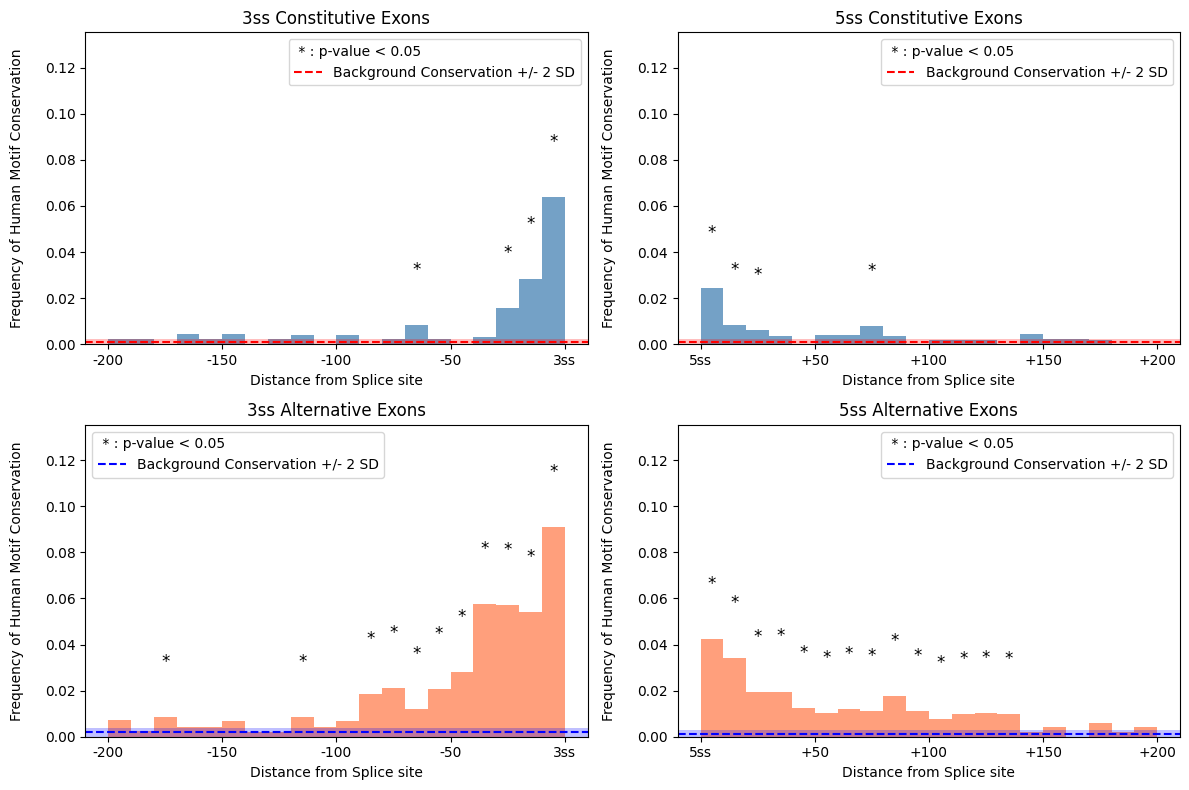

In [13]:
# Graphing results for splicing factors

rbfox = 'GCATG' # Good
#dazap1 = 'TATAG' # Decent
hnrnpk = 'CCATT' # Good
hnrnpc = 'TTTTA' # Good
#hnrnpf = 'GGGGA' # Decent
pcbp1 = 'CCTTT' # Good
ptbp3 = 'CTTTC' # Good

motif = ptbp3

plot_ss_conserved(motif, *ortho_seq_conserved_motif(motif, species[:], final_alternative_orthologs, 250, 250, edge = 5),\
                     *ortho_seq_conserved_motif(motif, species[:], final_constitutive_orthologs, 250, 250, edge = 5), False)

In [54]:
# Extracting the top RBPamp motif to match with splicing factor.

matrix_rows = []

file_path = '/Users/nrk/Desktop/PhD/Database/03_PSAMs/PTBP3.txt'

with open(file_path, 'r') as f:
    for line in f:
        # Skip headers and comments
        if line.startswith("#") or line.startswith("runinfo:") or line.strip() == "":
            continue
        
        # Split line into tokens
        parts = line.strip().split()
        
        # Only process lines with 5 columns (4 probs + consensus letter)
        if len(parts) == 5:
            matrix_rows.append(parts[:-1])

# Create DataFrame
df = pd.DataFrame(matrix_rows, columns=["A", "C", "G", "U"])

# Convert numeric columns from strings to floats
df[["A", "C", "G", "U"]] = df[["A", "C", "G", "U"]].astype(float)

np.argmax(matrix_rows, axis =1)[:11], np.argmax(matrix_rows, axis =1)[11:22,], np.argmax(matrix_rows, axis =1)[22:33], np.argmax(matrix_rows, axis =1)[33:44],  np.argmax(matrix_rows, axis =1)[44:55]

(array([3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3]),
 array([1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3]),
 array([1, 3, 3, 3, 0, 1, 3, 0, 3, 0, 3]),
 array([1, 3, 3, 1, 3, 0, 3, 1, 3, 3, 3]),
 array([1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 0]))

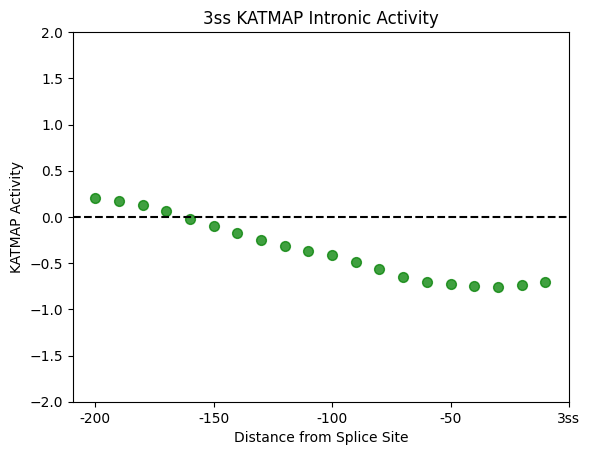

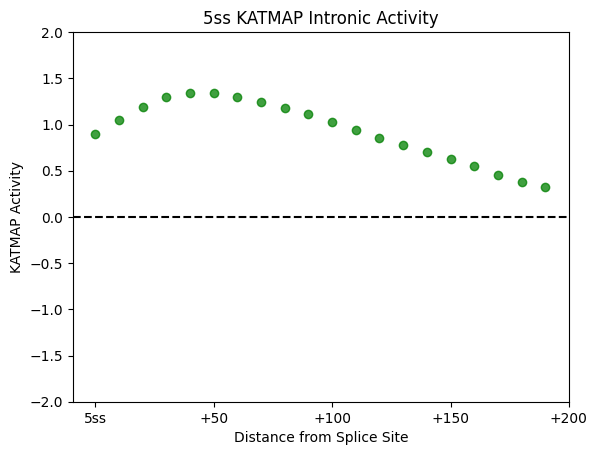

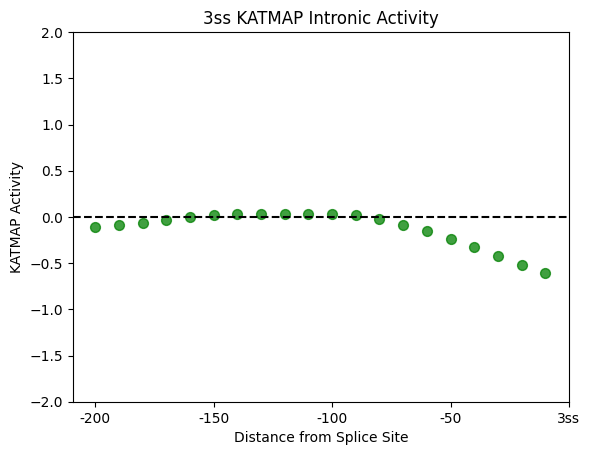

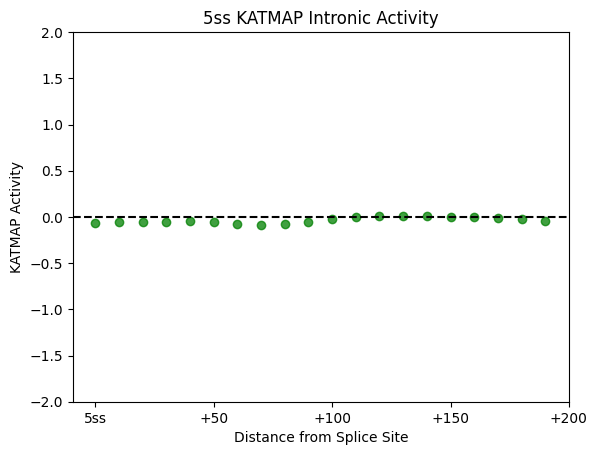

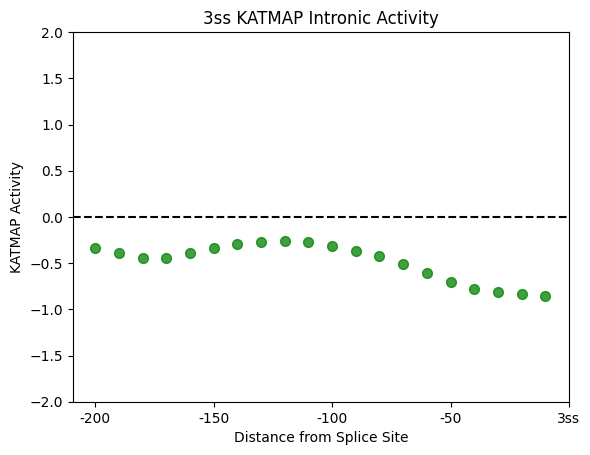

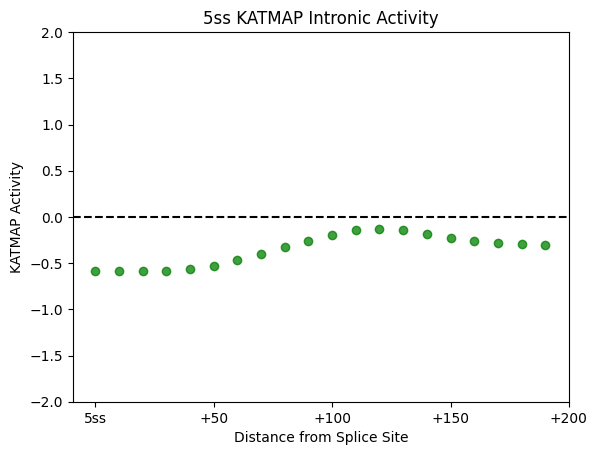

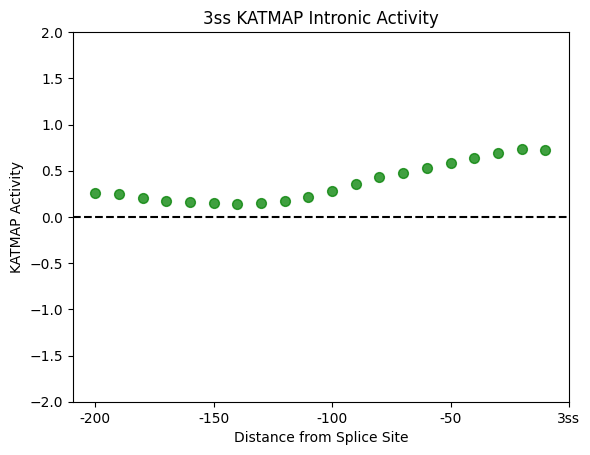

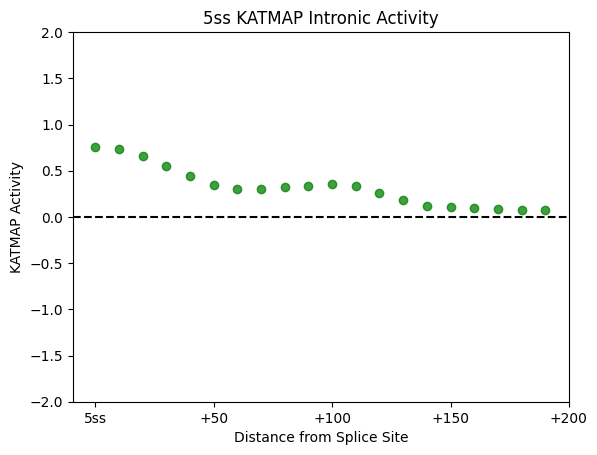

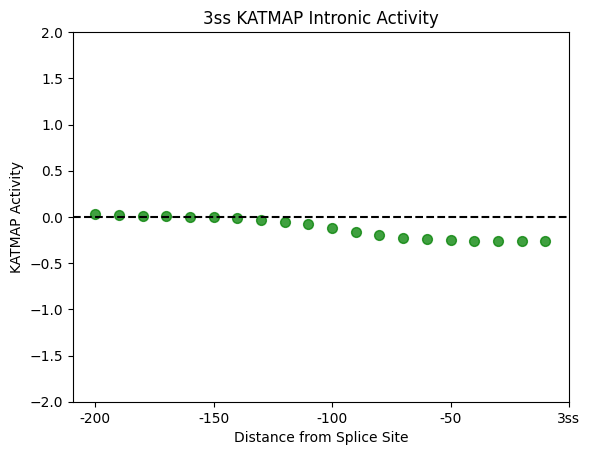

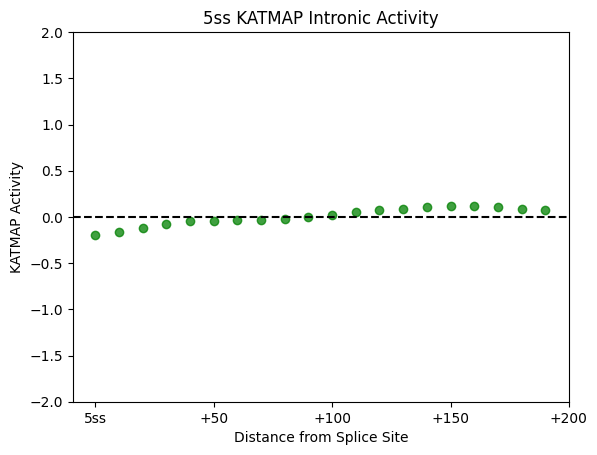

In [48]:
# Making KATMAP figures myself to match dimensions and style of conservation plots.
# Will put final figure together myself. More often than not, subplotting adds unnecessary difficulty.

katmap_activity = pd.read_csv(database + 'katmap_activities.tsv', sep='\t')

# 11 RBFOX, 4 HNRNP K, 1 HNRNP C, 7 PCBP1, 8 PTBP1.
# 1:21 is 3ss, 33: is 5ss

sf_indices = {rbfox:11, hnrnpk:4, hnrnpc:1, pcbp1:7, ptbp3:8}

for motif in [rbfox, hnrnpk, hnrnpc, pcbp1, ptbp3]:

    three_activity = katmap_activity.iloc[sf_indices[motif], 1:21]
    five_activity = katmap_activity.iloc[sf_indices[motif], 33:]
    plt.scatter(range(0,200,10), three_activity, c = 'green', alpha = 0.75, s = 50)
    plt.xticks([200, 150, 100, 50, 0], ["3ss", "-50", "-100", "-150", "-200"])
    plt.title('3ss KATMAP Intronic Activity')
    plt.ylabel('KATMAP Activity')
    plt.xlabel('Distance from Splice Site')
    plt.ylim([-2,2])
    plt.axhline(y = 0, color = 'black', ls = '--')
    plt.show()
    
    plt.scatter(range(0,200,10), five_activity, c = 'green', alpha = 0.75)
    plt.title('5ss KATMAP Intronic Activity')
    plt.ylabel('KATMAP Activity')
    plt.xlabel('Distance from Splice Site')
    plt.xticks([0, 50, 100, 150, 200], ["5ss", "+50", "+100", "+150", "+200"])
    plt.ylim([-2,2])
    plt.axhline(y = 0, color = 'black', ls = '--')
    plt.show()

GCATG




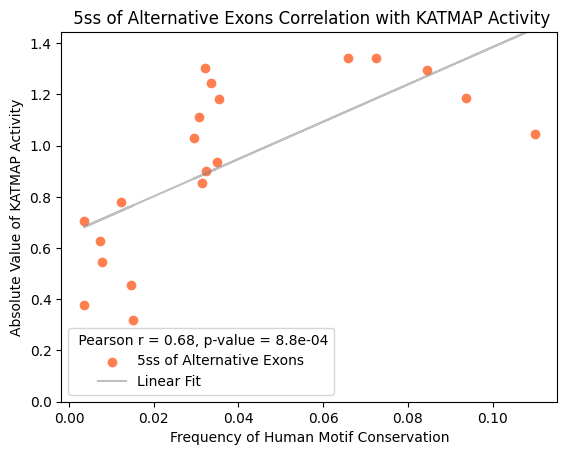

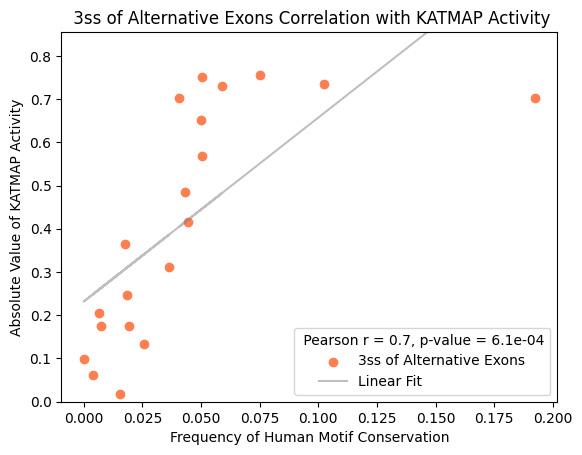

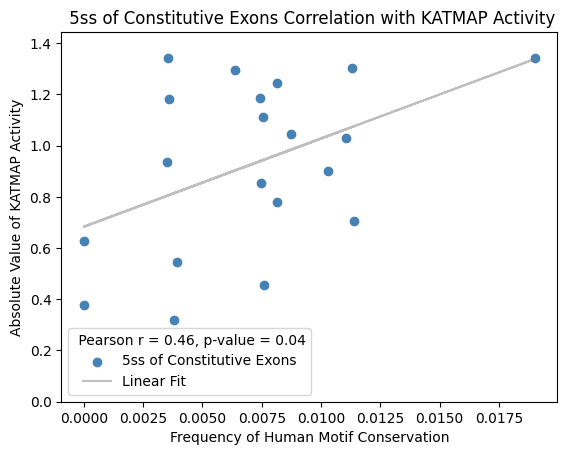

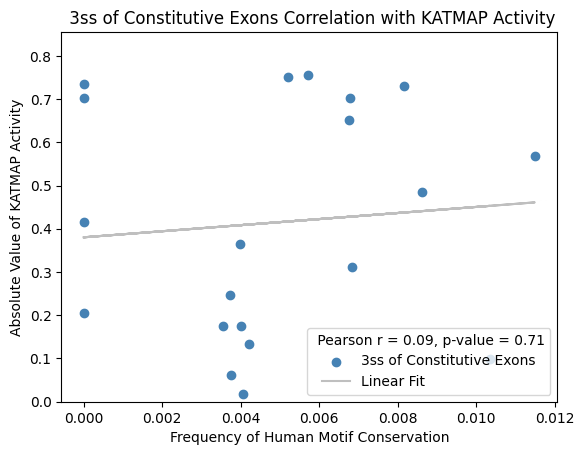

CCATT




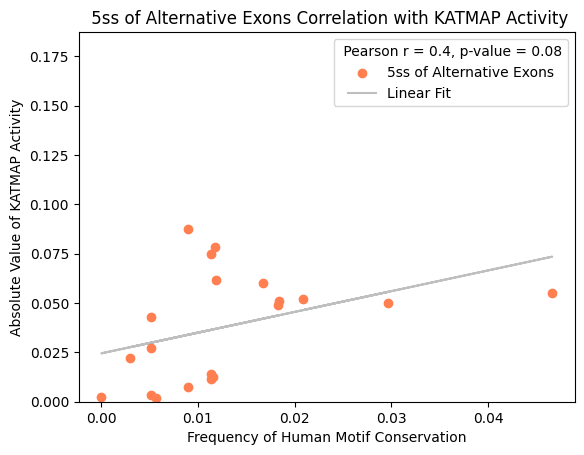

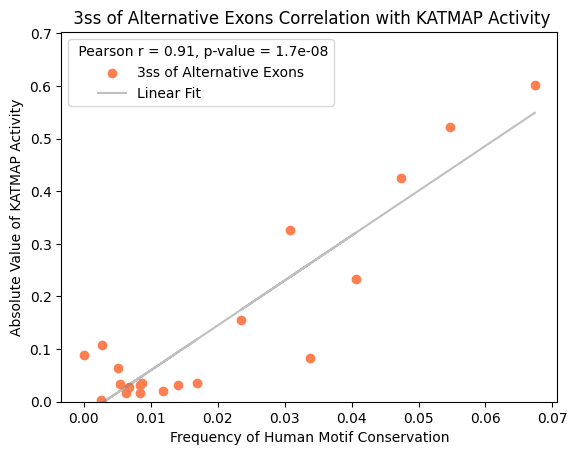

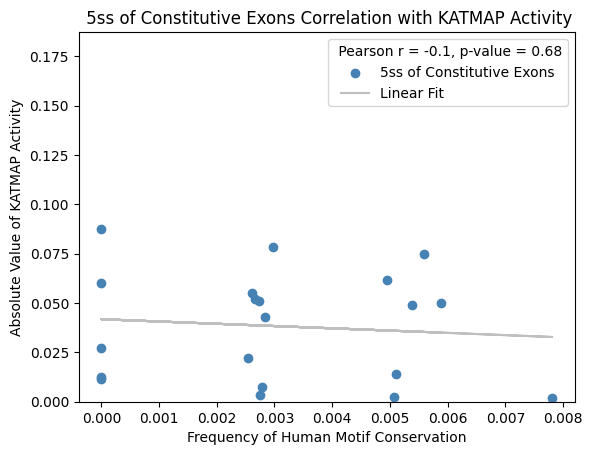

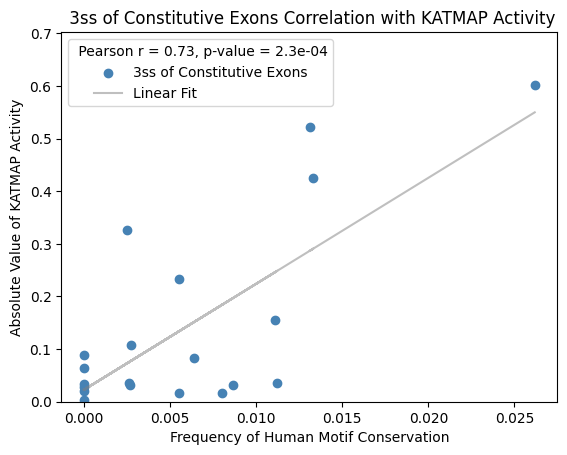

TTTTA




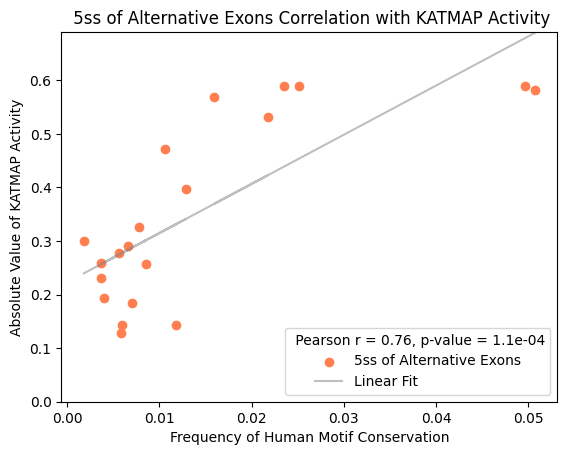

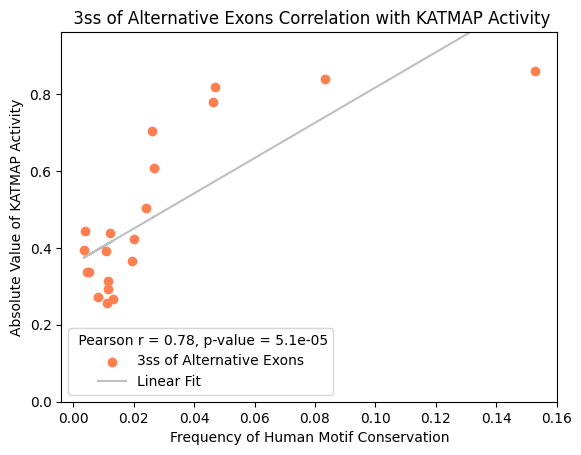

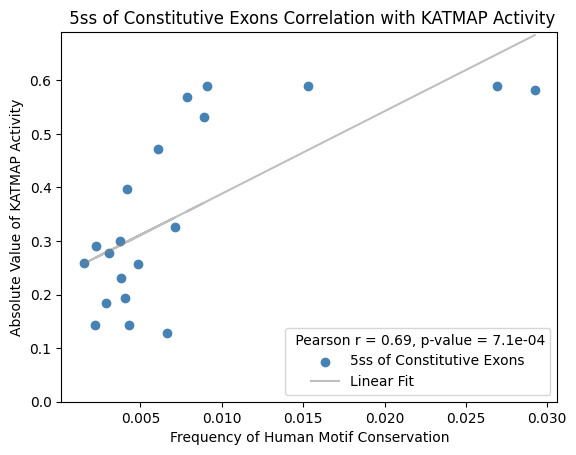

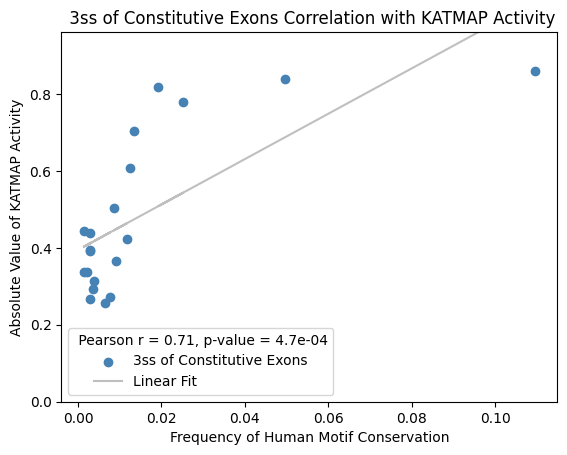

CCTTT




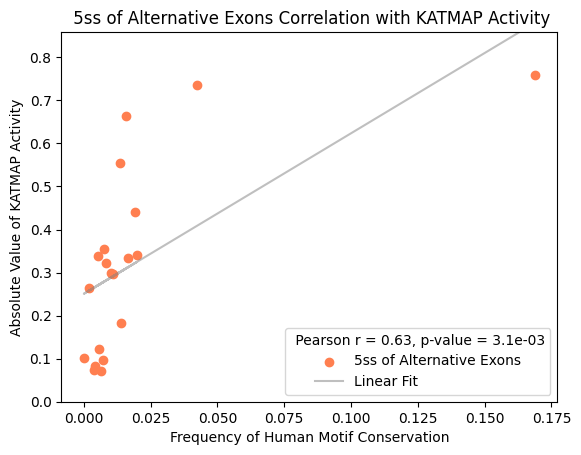

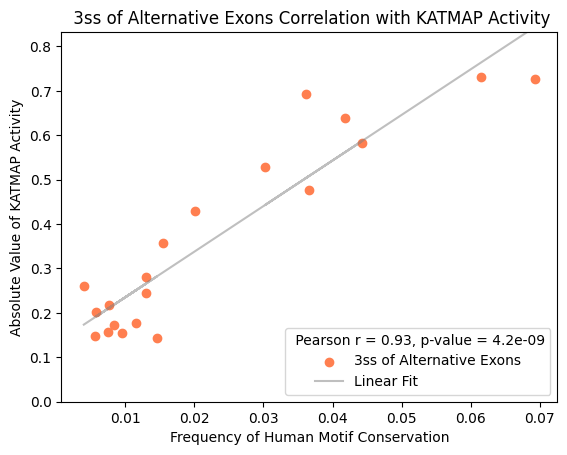

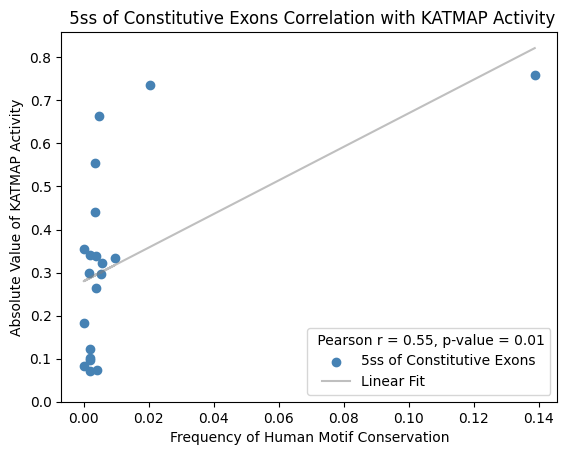

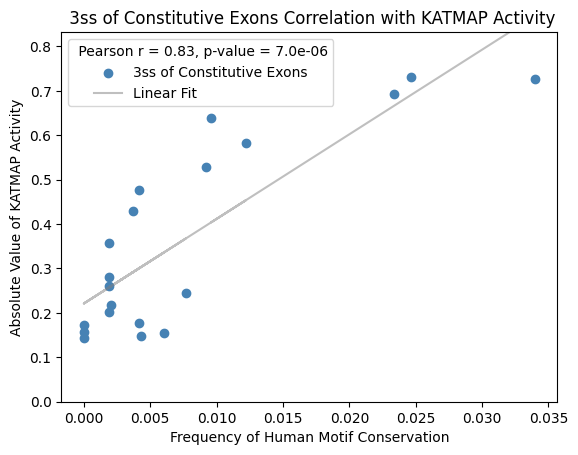

CTTTC




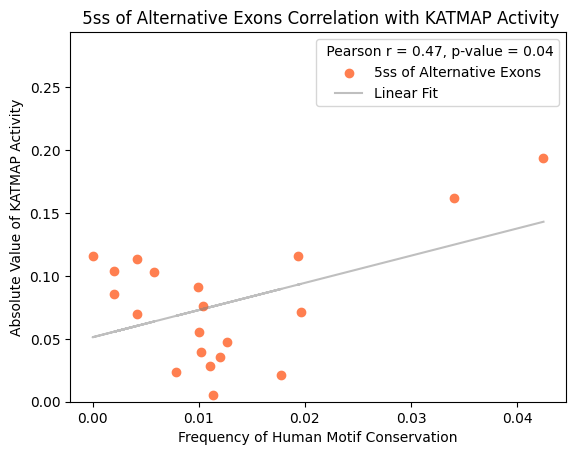

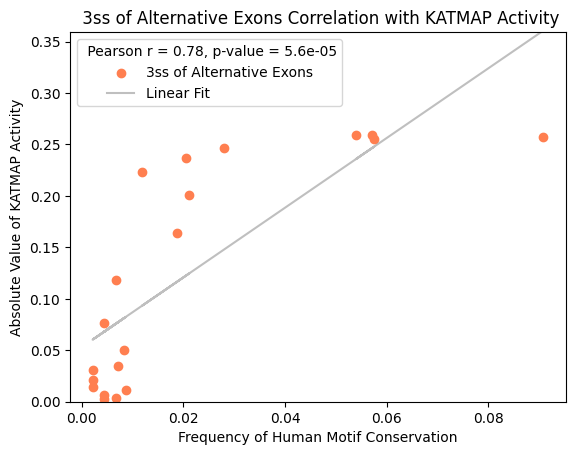

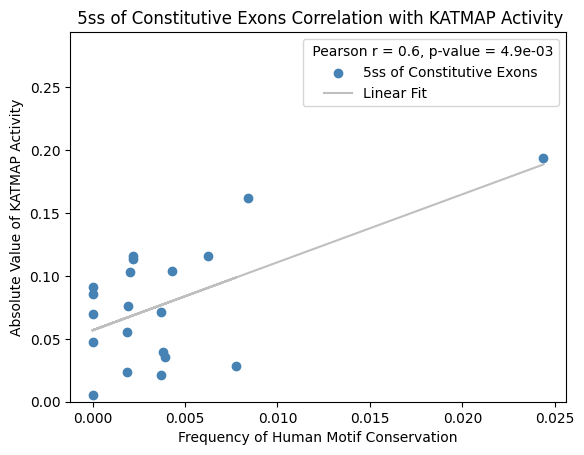

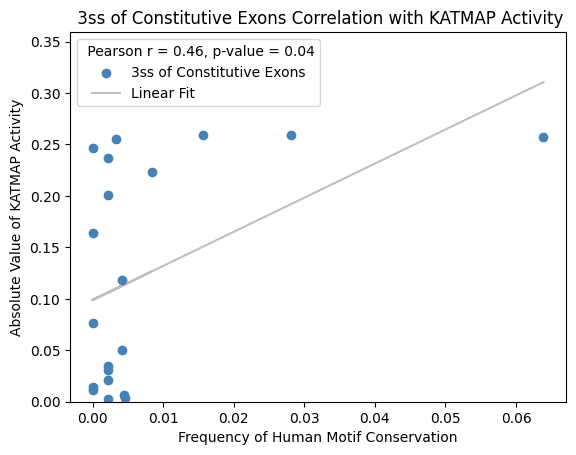

In [47]:
# Loading katmap activity values for correlation against the conservation bins.
# Repetitive code, but keeping this way in case I need to adjust later.

bin_size = 10

for motif in [rbfox, hnrnpk, hnrnpc, pcbp1, ptbp3]:
    print(motif)
    print('\n')
    conserved_alt5, enrichment_alt5, conserved_alt3, enrichment_alt3 = ortho_seq_conserved_motif(motif, species[:], final_alternative_orthologs, 250, 250, edge = 5)
    conserved_const5, enrichment_const5, conserved_const3, enrichment_const3 = ortho_seq_conserved_motif(motif, species[:], final_constitutive_orthologs, 250, 250, edge = 5)

    # Conservation values for alterntative orthologs
    conserve_vals_alt5 = np.reshape(conserved_alt5[0:200], (-1, bin_size)).sum(axis=1) / np.reshape(enrichment_alt5[0:200], (-1, bin_size)).sum(axis=1)
    conserve_vals_alt3 = np.reshape(conserved_alt3[50:250], (-1, bin_size)).sum(axis=1) / np.reshape(enrichment_alt3[50:250], (-1, bin_size)).sum(axis=1)

    # Conservation values for constitutive orthologs
    conserve_vals_const5 = np.reshape(conserved_const5[0:200], (-1, bin_size)).sum(axis=1) / np.reshape(enrichment_const5[0:200], (-1, bin_size)).sum(axis=1)
    conserve_vals_const3 = np.reshape(conserved_const3[50:250], (-1, bin_size)).sum(axis=1) / np.reshape(enrichment_const3[50:250], (-1, bin_size)).sum(axis=1)

    data1 = np.abs(katmap_activity.iloc[sf_indices[motif], 33:])
    plt.scatter(conserve_vals_alt5, data1, color = 'coral', label = '5ss of Alternative Exons')
    slope, intercept, r_value, p_value, std_err = stats.linregress(conserve_vals_alt5, list(data1))
    regression_line = [slope * xi + intercept for xi in conserve_vals_alt5]
    plt.plot(conserve_vals_alt5, regression_line, color='grey', alpha = 0.5, label='Linear Fit')
    plt.ylim([0, np.max(data1) + 0.1])
    plt.title(f" 5ss of Alternative Exons Correlation with KATMAP Activity")
    plt.xlabel('Frequency of Human Motif Conservation')
    plt.ylabel('Absolute Value of KATMAP Activity')
    corr_results = stats.pearsonr(conserve_vals_alt5, list(data1), alternative = 'two-sided')
    if corr_results[1] < 0.01:
        temp_str = f'{corr_results[1]:.1e}'
    else:
        temp_str = f'{corr_results[1]:.2f}'
    
    plt.legend(title = f' Pearson r = {round(corr_results[0], 2)}, p-value = {temp_str}')
    plt.show()


    data2 = np.abs(katmap_activity.iloc[sf_indices[motif], 1:21])
    plt.scatter(conserve_vals_alt3, data2, color = 'coral', label = '3ss of Alternative Exons')

    slope, intercept, r_value, p_value, std_err = stats.linregress(conserve_vals_alt3, list(data2))
    regression_line = [slope * xi + intercept for xi in conserve_vals_alt3]
    plt.plot(conserve_vals_alt3, regression_line, color='grey', alpha = 0.5, label='Linear Fit')
    plt.ylim([0, np.max(data2) + 0.1])

    plt.title(f" 3ss of Alternative Exons Correlation with KATMAP Activity")
    plt.xlabel('Frequency of Human Motif Conservation')
    plt.ylabel('Absolute Value of KATMAP Activity')
    corr_results = stats.pearsonr(conserve_vals_alt3, list(data2), alternative = 'two-sided')
    
    if corr_results[1] < 0.01:
        temp_str = f'{corr_results[1]:.1e}'
    else:
        temp_str = f'{corr_results[1]:.2f}'
    
    plt.legend(title = f' Pearson r = {round(corr_results[0], 2)}, p-value = {temp_str}')
    plt.show()


    data3 = np.abs(katmap_activity.iloc[sf_indices[motif], 33:])
    plt.scatter(conserve_vals_const5, data3, color = 'steelblue', label = '5ss of Constitutive Exons')
    slope, intercept, r_value, p_value, std_err = stats.linregress(conserve_vals_const5, list(data3))
    regression_line = [slope * xi + intercept for xi in conserve_vals_const5]
    plt.plot(conserve_vals_const5, regression_line, color='grey', alpha = 0.5, label='Linear Fit')
    plt.ylim([0, np.max(data3) + 0.1])

    plt.title(f" 5ss of Constitutive Exons Correlation with KATMAP Activity")
    plt.xlabel('Frequency of Human Motif Conservation')
    plt.ylabel('Absolute Value of KATMAP Activity')
    corr_results = stats.pearsonr(conserve_vals_const5, list(data3), alternative = 'two-sided')
    
    if corr_results[1] < 0.01:
        temp_str = f'{corr_results[1]:.1e}'
    else:
        temp_str = f'{corr_results[1]:.2f}'
    plt.legend(title = f' Pearson r = {round(corr_results[0], 2)}, p-value = {temp_str}')
    plt.show()


    data4 = np.abs(katmap_activity.iloc[sf_indices[motif], 1:21])
    plt.scatter(conserve_vals_const3, data4, color = 'steelblue', label = '3ss of Constitutive Exons')

    slope, intercept, r_value, p_value, std_err = stats.linregress(conserve_vals_const3, list(data4))
    regression_line = [slope * xi + intercept for xi in conserve_vals_const3]
    plt.plot(conserve_vals_const3, regression_line, color='grey', alpha = 0.5, label='Linear Fit')
    
    plt.ylim([0, np.max(data4) + 0.1])

    plt.title(f" 3ss of Constitutive Exons Correlation with KATMAP Activity")
    plt.xlabel('Frequency of Human Motif Conservation')
    plt.ylabel('Absolute Value of KATMAP Activity')
    corr_results = stats.pearsonr(conserve_vals_const3, list(data4), alternative = 'two-sided')
    if corr_results[1] < 0.01:
        temp_str = f'{corr_results[1]:.1e}'
    else:
        temp_str = f'{corr_results[1]:.2f}'
        
    plt.legend(title = f' Pearson r = {round(corr_results[0], 2)}, p-value = {temp_str}')
    plt.show()

